# **Tahap 1: Hitung Entropi per Ayat**

## **Import Library**

In [1]:
import pandas as pd
import re
from collections import Counter
from math import log2
import matplotlib.pyplot as plt


## **Memuat Dataset**

In [2]:
df = pd.read_csv('quran_indonesia.csv')

In [3]:
# Fungsi preprocessing: hapus tanda baca, lowercase, tokenisasi
def preprocess(text, level='word'):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # hapus tanda baca
    return text.split() if level == 'word' else list(text.replace(" ", ""))

## **Preprocessing Data**

In [4]:
# Fungsi hitung entropi
def shannon_entropy(tokens):
    total = len(tokens)
    if total == 0:
        return 0
    freqs = Counter(tokens)
    probs = [count / total for count in freqs.values()]
    return -sum(p * log2(p) for p in probs)

## **Hitung Entropi**

In [5]:
# Hitung entropi per ayat (berdasarkan token kata)
df['tokens'] = df['teks'].apply(lambda x: preprocess(x, level='word'))
df['entropy'] = df['tokens'].apply(shannon_entropy)

In [6]:
# Lihat hasilnya
print(df[['surah', 'ayat', 'teks', 'entropy']])

      surah  ayat                                               teks   entropy
0         1     1  Dengan menyebut nama Allah Yang Maha Pemurah l...  3.121928
1         1     2        Segala puji bagi Allah, Tuhan semesta alam.  2.807355
2         1     3                  Maha Pemurah lagi Maha Penyayang.  1.921928
3         1     4                 Yang menguasai di Hari Pembalasan.  2.321928
4         1     5  Hanya Engkaulah yang kami sembah, dan hanya ke...  3.084963
...     ...   ...                                                ...       ...
6231    114     2                                      Raja manusia.  1.000000
6232    114     3                                  Sembahan manusia.  1.000000
6233    114     4  Dari kejahatan (bisikan) syaitan yang biasa be...  2.807355
6234    114     5  yang membisikkan (kejahatan) ke dalam dada man...  2.807355
6235    114     6                   dari (golongan) jin dan manusia.  2.321928

[6236 rows x 4 columns]


## **A. Hitung Rata-rata Entropi per Surat**

In [7]:
entropi_per_surat = df.groupby('surah')['entropy'].mean().reset_index()
print(entropi_per_surat)


     surah   entropy
0        1  2.757166
1        2  4.606570
2        3  4.434265
3        4  4.609723
4        5  4.732669
..     ...       ...
109    110  3.294724
110    111  3.085698
111    112  2.848079
112    113  2.742849
113    114  2.209761

[114 rows x 2 columns]


## **B. Visualisasi**

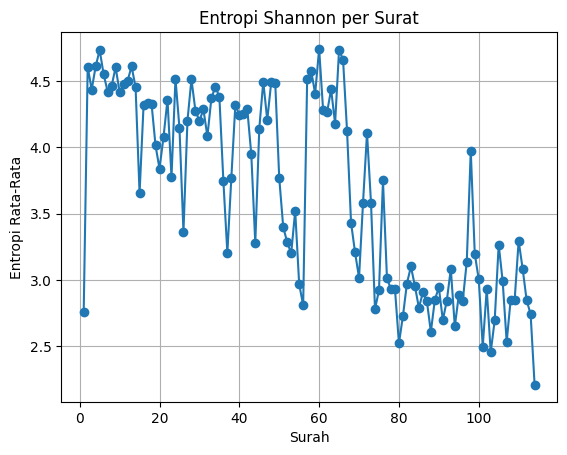

In [8]:

plt.plot(entropi_per_surat['surah'], entropi_per_surat['entropy'], marker='o')
plt.xlabel("Surah")
plt.ylabel("Entropi Rata-Rata")
plt.title("Entropi Shannon per Surat")
plt.grid()
plt.show()

## **Insight**